In [1]:
#| default_exp processing.tiling

# Tiling

> Tiling for both raster and vector data

In [2]:
#| hide
from nbdev.showdoc import *
import warnings
warnings.filterwarnings("ignore")

In [3]:
#| export

from drone_detector.imports import *
from drone_detector.utils import *
from drone_detector.processing.postproc import *
import rasterio.mask as rio_mask
import rasterio.windows as rio_windows


In [4]:
#| hide

def make_grid(path, gridsize_x:int=640, gridsize_y:int=480, 
              overlap:Tuple[int, int]=(100,100)) -> gpd.GeoDataFrame:
    """
    Creates a grid template with `gridsize_x` times `gridsize_y` cells, with `overlap` pixels of overlap based on geotiff file in `path`. Returns a gpd.GeoDataFrame with `RyyCxx` identifier for each geometry BUGGED and replaced with rio_windows in tile_raster
    """
    with rio.open(path) as src:
        tfm = src.transform
        x_size = src.width
        y_size = src.height
    xres = tfm[0]
    ulx = tfm[2]
    yres = tfm[4]
    uly = tfm[5]
    lrx = ulx + (x_size * xres)
    lry = uly + (y_size * yres)
    # number of output cells is calculated like conv output
    ncols = int(np.ceil((np.ceil((lrx - ulx) / xres)) - gridsize_x) / (gridsize_x - overlap[0]) + 1)
    nrows = int(np.ceil((np.ceil((lry - uly) / yres)) - gridsize_y) / (gridsize_y - overlap[1]) + 1)
    polys = []
    names = []
    for col, row in (itertools.product(range(ncols), range(nrows))):
        ytop = lry - row * (yres * (gridsize_y - overlap[1]))
        ybot = ytop - (yres * gridsize_y)
        xleft = ulx + col * (xres * (gridsize_x - overlap[0]))
        xright = xleft + (xres * gridsize_x)
        polys.append(Polygon([(xleft,ytop), (xright,ytop), (xright,ybot), (xleft,ybot)]))
        names.append(f'R{row}C{col}')
    grid = gpd.GeoDataFrame({'cell': names, 'geometry':polys})
    
    with rio.open(path) as src:
        crs = src.crs
    grid.crs = crs
    
    return grid

In [5]:
#| export

class Tiler():
    """
    Similar functions than ´solaris.tile.raster_tile' but with more recent dependencies. 
    """
    def __init__(self, outpath, gridsize_x:int=400, gridsize_y:int=400, 
                 overlap:Tuple[int, int]=(100, 100)):
        store_attr()
        self.grid = None
        if not os.path.exists(outpath): os.makedirs(outpath)
            
        self.raster_path = f'{self.outpath}/images'
        self.vector_path = f'{self.outpath}/vectors'
        self.rasterized_vector_path = f'{self.outpath}/rasterized_vectors'
        
    def tile_raster(self, path_to_raster:str, allow_partial_data:bool=False) -> None:
        "Tiles specified raster to `self.gridsize_x` times `self.gridsize_y` grid, with `self.overlap` pixel overlap"
        names = []
        polys = []
        col_id = 0
        row_id = 0
        
        if not os.path.exists(self.raster_path): os.makedirs(self.raster_path)
        with rio.open(path_to_raster) as src:
            y, x = src.shape
            
            for (iy, dy), (ix, dx) in tqdm(itertools.product(enumerate(range(0, y, self.gridsize_y-self.overlap[1])), 
                                                             enumerate(range(0, x, self.gridsize_x-self.overlap[0])))):
                
                if dy+self.gridsize_y > y and not allow_partial_data: continue
                if dx+self.gridsize_x > x and not allow_partial_data: continue
                window = rio_windows.Window.from_slices((dy, dy+self.gridsize_y),
                                                        (dx, dx+self.gridsize_x))
                prof = src.profile.copy()
                prof.update(
                    height=window.height,
                    width=window.width,
                    transform= rio_windows.transform(window, src.transform),
                    compress='lzw',
                    predictor=2
                )
                fname = f'R{iy}C{ix}'
                data = src.read(window=window)
                if data.shape[1] < window.height or data.shape[2] < window.width:
                    newdata = np.zeros((data.shape[0], window.height, window.width))
                    newdata[:, :data.shape[1], :data.shape[2]] = data
                    data = newdata
                with rio.open(f'{self.raster_path}/{fname}.tif', 'w', **prof) as dest:
                    dest.write(data)
                    polys.append(box(*dest.bounds))
                names.append(fname)
            self.grid = gpd.GeoDataFrame({'cell': names, 'geometry':polys}, crs=src.crs)  
        return
    
    
    def tile_vector(self, path_to_vector:str, min_area_pct:float=0.0) -> None:
        """
        Tiles a vector data file into smaller tiles. Converts all multipolygons to a regular polygons. `min_area_pct` is be used to specify the minimum area for partial masks to keep. Default value 0.0 keeps all masks.
        """
        if self.grid is None:
            print('No raster grid specified, use Tiler.tile_raster to determine grid limits')
            return
        
        if not os.path.exists(self.vector_path): os.makedirs(self.vector_path)
        vector = gpd.read_file(path_to_vector)
        # God bless spatial index
        sindex = vector.sindex
        for row in tqdm(self.grid.itertuples()):
            possible_matches_index = list(sindex.intersection(row.geometry.bounds))
            tempvector = vector.iloc[possible_matches_index].copy()
            tempvector['orig_area'] = tempvector.geometry.area
            tempvector = tempvector.clip(row.geometry, keep_geom_type=True)

            if min_area_pct < 0 or min_area_pct >= 1:
                print('Invalid minimum area percentage set, defaulting to 0')
            tempvector = tempvector[tempvector.geometry.area >= tempvector.orig_area * min_area_pct]
            # No annotations -> no shapefile
            if len(tempvector) == 0: continue            
            tempvector['geometry'] = tempvector.apply(lambda row: fix_multipolys(row.geometry) 
                                                      if row.geometry.geom_type == 'MultiPolygon'
                                                      else shapely.geometry.Polygon(row.geometry.exterior), axis=1)
            

            tempvector.to_file(f'{self.vector_path}/{row.cell}.geojson', driver='GeoJSON')
        return
    
    def tile_and_rasterize_vector(self, path_to_raster:str, path_to_vector:str, column:str,
                                  keep_bg_only:bool=False) -> None:
        """Rasterizes vectors based on tiled rasters. Requires that shapefile has numeric data in `column`. By default only keeps the patches that contain polygon data, by specifying `keep_bg_only=True` saves also masks for empty patches."""
        if not os.path.exists(self.rasterized_vector_path):
            os.makedirs(self.rasterized_vector_path)
        
        vector = gpd.read_file(path_to_vector)

        with rio.open(path_to_raster) as src:
            for row in tqdm(self.grid.itertuples()):
                out_im, out_tfm = rio_mask.mask(src, [row.geometry], crop=True)
                out_meta = src.meta
                out_meta.update({'driver':'GTiff',
                                 'height': out_im.shape[1],
                                 'width': out_im.shape[2],
                                 'transform': out_tfm,
                                 'compress':'lzw',
                                 'count':1})
                tempvector = vector.clip(row.geometry, keep_geom_type=True)
                with rio.open(f'{self.rasterized_vector_path}/{row.cell}.tif', 'w+', **out_meta) as dest:
                    dest_arr = dest.read(1)
                    shapes = ((geom,value) for geom, value in zip(tempvector.geometry, tempvector[column]))
                    if len(tempvector) == 0: 
                        if keep_bg_only: dest.write_band(1, dest_arr)
                        continue
                    burned = rio.features.rasterize(shapes=shapes, fill=0, out=dest_arr, transform=dest.transform)
                    dest.write_band(1, burned)   
        return

In [6]:
show_doc(Tiler.tile_raster)

---

[source](https://github.com/mayrajeo/drone_detector/tree/master/blob/master/drone_detector/processing/tiling.py#L29){target="_blank" style="float:right; font-size:smaller"}

### Tiler.tile_raster

>      Tiler.tile_raster (path_to_raster:str, allow_partial_data:bool=False)

Tiles specified raster to `self.gridsize_x` times `self.gridsize_y` grid, with `self.overlap` pixel overlap

In [7]:
show_doc(Tiler.tile_vector)

---

[source](https://github.com/mayrajeo/drone_detector/tree/master/blob/master/drone_detector/processing/tiling.py#L69){target="_blank" style="float:right; font-size:smaller"}

### Tiler.tile_vector

>      Tiler.tile_vector (path_to_vector:str, min_area_pct:float=0.0)

Tiles a vector data file into smaller tiles. Converts all multipolygons to a regular polygons. `min_area_pct` is be used to specify the minimum area for partial masks to keep. Default value 0.0 keeps all masks.

In [8]:
show_doc(Tiler.tile_and_rasterize_vector)

---

[source](https://github.com/mayrajeo/drone_detector/tree/master/blob/master/drone_detector/processing/tiling.py#L100){target="_blank" style="float:right; font-size:smaller"}

### Tiler.tile_and_rasterize_vector

>      Tiler.tile_and_rasterize_vector (path_to_raster:str, path_to_vector:str,
>                                       column:str, keep_bg_only:bool=False)

Rasterizes vectors based on tiled rasters. Requires that shapefile has numeric data in `column`. By default only keeps the patches that contain polygon data, by specifying `keep_bg_only=True` saves also masks for empty patches.

In [9]:
#| export

def untile_raster(path_to_targets:str, outfile:str, method:str='first'):
    """Merge multiple patches from `path_to_targets` into a single raster`"""

    rasters = [f'{path_to_targets}/{f}' for f in os.listdir(path_to_targets) if f.endswith('.tif')]
    
    if method == 'sum': method = copy_sum
    
    files_to_mosaic = []
       
    for f in rasters:
        src = rio.open(f)
        files_to_mosaic.append(src)
    
    mosaic, out_tfm = rio_merge(files_to_mosaic, method=method)
    
    out_meta = src.meta.copy()
    out_meta.update({'driver': 'GTiff',
                     'height': mosaic.shape[1],
                     'width': mosaic.shape[2],
                     'transform': out_tfm,
                     'crs': src.crs})
    
    with rio.open(outfile, 'w', **out_meta) as dest: dest.write(mosaic)
    
def copy_sum(merged_data, new_data, merged_mask, new_mask, **kwargs):
    "Make new pixels have the sum of two overlapping pixels as their value. Useful with prediction data"
    newregion = merged_data + new_data
    np.copyto(merged_data, newregion)    
    
def untile_vector(path_to_targets:str, outpath:str, non_max_suppression_thresh:float=0.0, nms_criterion:str='score'):
    "Create single shapefile from a directory of predicted shapefiles"
    pred_files = [f for f in os.listdir(path_to_targets) if f.endswith(('.shp', '.geojson'))]
    gdf = None
    for p in tqdm(pred_files):
        temp_gdf = gpd.read_file(f'{path_to_targets}/{p}')
        if gdf is None: gdf = temp_gdf
        else: gdf = gdf.append(temp_gdf)
    print(f'{len(gdf)} polygons before non-max suppression')
    if non_max_suppression_thresh != 0:
        np_bounding_boxes = np.array([b.bounds for b in gdf.geometry])
        scores = gdf.score.values
        idxs = non_max_suppression_fast(np_bounding_boxes, scores, 
                                        overlap_thresh=non_max_suppression_thresh,
                                        sort_criterion=nms_criterion)
        gdf = gdf.iloc[idxs]
    print(f'{len(gdf)} polygons after non-max suppression')
    if outpath.endswith('shp'):
        gdf.to_file(outpath)
    elif outpath.endswith('geojson'):
        gdf.to_file(outpath, driver='GeoJSON')
    return

In [10]:
f = gpd.read_file('example_data/R70C21.shp')
f.head()
f['label_id'] = f.apply(lambda row: 2 if row.label == 'Standing' else 1, axis=1)
f.to_file('example_data/R70C21.shp')

Example area looks like this

In [11]:
from rasterio import plot as rioplot

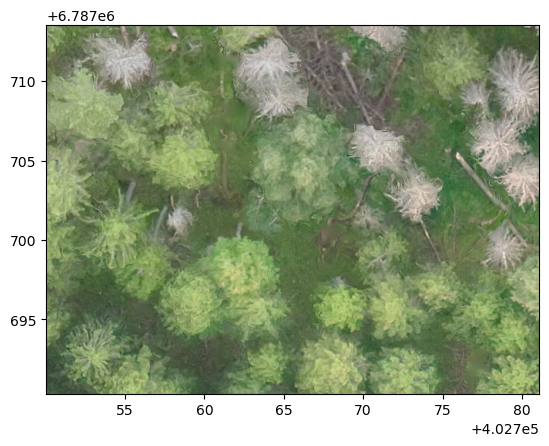

<AxesSubplot:>

In [12]:
raster = rio.open('example_data/R70C21.tif')
rioplot.show(raster)

With `rasterio.plot` it is a lot easier to visualize shapefile and raster simultaneously

<AxesSubplot:>

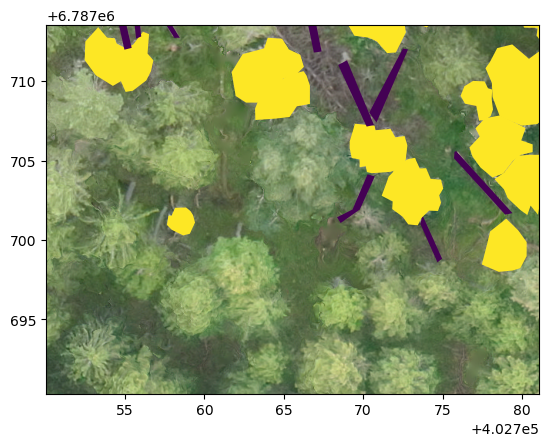

In [13]:
fig, ax = plt.subplots(1,1)
rioplot.show(raster, ax=ax)
f.plot(ax=ax, column='label_id')

Let's tile image into 240x180 sized patches using overlap of half patch size.

In [42]:
tiler = Tiler(outpath='example_data/tiles', gridsize_x=240, gridsize_y=180, overlap=(120, 90))

In [43]:
tiler.tile_raster('example_data/R70C21.tif')

0it [00:00, ?it/s]

In [44]:
tiler.tile_vector('example_data/R70C21.shp', min_area_pct=.2)

0it [00:00, ?it/s]

Untile shapefiles and check how they look

In [45]:
untile_vector(f'example_data/tiles/vectors', outpath='example_data/untiled.geojson')

  0%|          | 0/21 [00:00<?, ?it/s]

81 polygons before non-max suppression
81 polygons after non-max suppression


Plot with the tiled grid.

<AxesSubplot:>

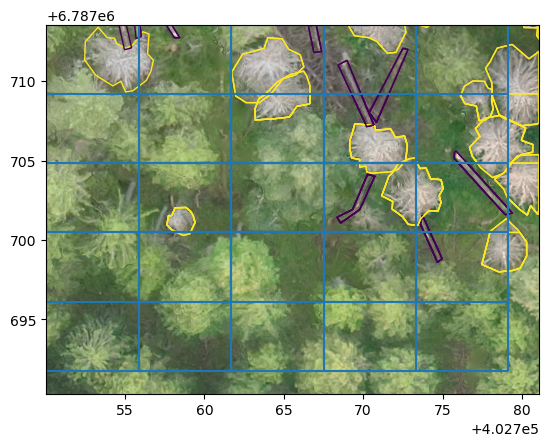

In [46]:
untiled = gpd.read_file('example_data/untiled.geojson')
fig, ax = plt.subplots(1,1)
rioplot.show(raster, ax=ax)
tiler.grid.exterior.plot(ax=ax)
untiled.plot(ax=ax, column='label_id', facecolor='none', edgecolor='black')

If `allow_partial_data=False` as is the default behaviour, tiling is done only for the area from which full sized patch can be extracted. With `allow_partial_data=True`, windows can "extend" to empty areas. This is useful with inference, when predicted areas can have wonky dimensions.

In [47]:
tiler.tile_raster('example_data/R70C21.tif', allow_partial_data=True)

0it [00:00, ?it/s]

In [48]:
tiler.tile_vector('example_data/R70C21.shp', min_area_pct=.2)

0it [00:00, ?it/s]

Untile shapefiles and check how they look

In [49]:
untile_vector(f'example_data/tiles/vectors', outpath='example_data/untiled.geojson')

  0%|          | 0/21 [00:00<?, ?it/s]

81 polygons before non-max suppression
81 polygons after non-max suppression


<AxesSubplot:>

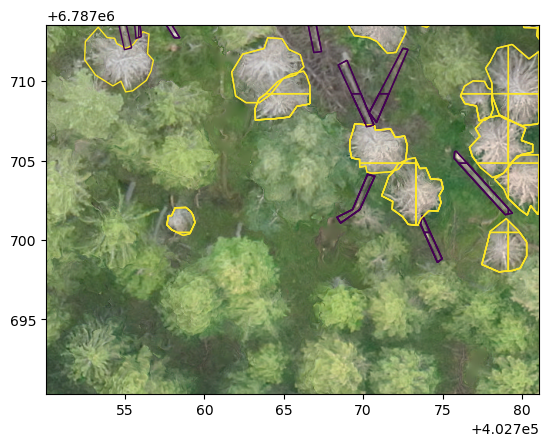

In [50]:
untiled = gpd.read_file('example_data/untiled.geojson')
fig, ax = plt.subplots(1,1)
rioplot.show(raster, ax=ax)
#tiler.grid.exterior.plot(ax=ax)
untiled.plot(ax=ax, column='label_id', facecolor='none', edgecolor='black')

Plot with the tiled grid.

<AxesSubplot:>

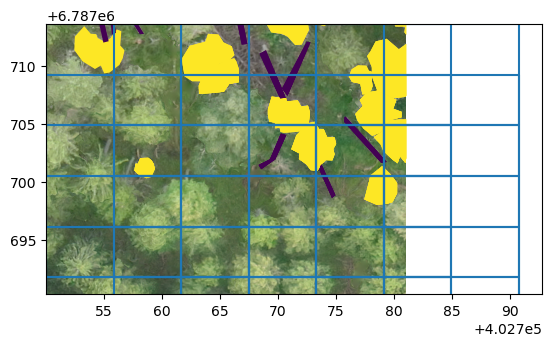

In [51]:
untiled = gpd.read_file('example_data/untiled.geojson')
fig, ax = plt.subplots(1,1)
rioplot.show(raster, ax=ax)
tiler.grid.exterior.plot(ax=ax)
untiled.plot(ax=ax, column='label_id')

In [52]:
tiler.tile_and_rasterize_vector('example_data/R70C21.tif', 'example_data/R70C21.shp', column='label_id')

0it [00:00, ?it/s]

In [53]:
tiler.tile_and_rasterize_vector('example_data/R70C21.tif', 'example_data/R70C21.shp', 
                                column='label_id', keep_bg_only=True)

0it [00:00, ?it/s]

In [54]:
import matplotlib.pyplot as plt

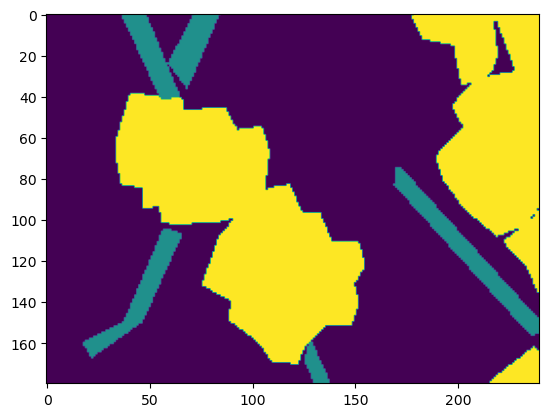

In [55]:
with rio.open('example_data/tiles/rasterized_vectors/R1C3.tif') as i: im = i.read()
plt.imshow(im[0])

`untile_raster` can be used to mosaic all patches into one.

In [56]:
untile_raster('example_data/tiles/rasterized_vectors/', 'example_data/tiles/mosaic_first.tif', 
              method='first')

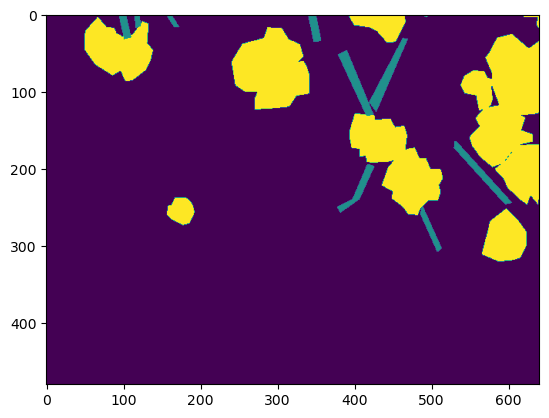

In [57]:
with rio.open('example_data/tiles/mosaic_first.tif') as mos: mosaic = mos.read()
plt.imshow(mosaic[0])

By specifying method as sum it's possible to collate predictions and get the most likely label for pixels

In [58]:
untile_raster('example_data/tiles/rasterized_vectors/', 'example_data/tiles/mosaic_sum.tif',
              method='sum')

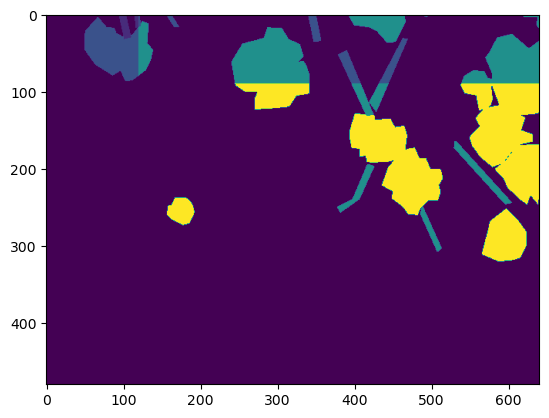

In [59]:
with rio.open('example_data/tiles/mosaic_sum.tif') as mos: mosaic = mos.read()
plt.imshow(mosaic[0])

In [60]:
#| hide

from nbdev import nbdev_export
nbdev_export()